In [ ]:
from datasets import load_dataset
from PIL import Image
import io

dataset = load_dataset("/home/huayu/pickapic_v2",split="validation_unique")

/home/huayu/miniconda3/envs/diffDPO/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Resolving data files: 100%|██████████| 645/645 [00:00<00:00, 423700.25it/s]


In [3]:
imageN= 2
prompts = dataset[:imageN]['caption']
raw_images = []
for i in range(imageN):
    jpg_0 = Image.open(io.BytesIO(dataset[i]['jpg_0'])).convert("RGB")
    jpg_1 = Image.open(io.BytesIO(dataset[i]['jpg_1'])).convert("RGB")
    prefered = jpg_0 if dataset[i]['label_0'] > 0.5 else jpg_1
    disprefered = jpg_1 if dataset[i]['label_0'] > 0.5 else jpg_0
    raw_images += [prefered, disprefered]

In [4]:
from diffusers import StableDiffusionPipeline, UNet2DConditionModel, StableDiffusionXLPipeline
import torch
# pretrained_model_name = "CompVis/stable-diffusion-v1-4"
pretrained_model_name = "/home/huayu/stable-diffusion-v1-5"
# pretrained_model_name = "stabilityai/stable-diffusion-xl-base-1.0"
gs = (5 if 'stable-diffusion-xl' in pretrained_model_name else 7.5)
torch.set_grad_enabled(False)
if 'stable-diffusion-xl' in pretrained_model_name:
    pipe = StableDiffusionXLPipeline.from_pretrained(
        pretrained_model_name, torch_dtype=torch.float16,
        variant="fp16", use_safetensors=True
    ).to("cuda")
else:
    pipe = StableDiffusionPipeline.from_pretrained(pretrained_model_name,
                                                   torch_dtype=torch.float16)
pipe = pipe.to('cuda')
pipe.safety_checker = None # Trigger-happy, blacks out >50% of "robot tiger"

Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  4.67it/s]


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [8]:
generator = torch.Generator(device='cuda')
generator = generator.manual_seed(0)
baseline_images = pipe(prompt=[item for item in prompts for _ in range(2)], generator=generator, guidance_scale=gs).images


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:09<00:00,  5.53it/s]


In [1]:
paths= ['/home/huayu/git/DiffusionDPO/tmp-sd15-fulltest-sft_latest22-0310/checkpoint-500',
        '/home/huayu/git/DiffusionDPO/tmp-sd15-fulltest-sft_latest22-0310/checkpoint-2000',
        "/home/huayu/git/DiffusionDPO/tmp-sd15-fulltest-dpo_latest22-0310/checkpoint-1000",
        "/home/huayu/git/DiffusionDPO/tmp-sd15-scoredpo_b1w1/checkpoint-500",
        ]
path_images = []
for path in paths:
    dpo_unet = UNet2DConditionModel.from_pretrained(
                                path,
                                # alternatively use local ckptdir (*/checkpoint-n/)
                                subfolder='unet',
                                torch_dtype=torch.float16
    ).to('cuda')
    pipe.unet = dpo_unet

    generator = torch.Generator(device='cuda')
    generator = generator.manual_seed(0)
    path_images.append(pipe(prompt=[item for item in prompts for _ in range(2)], generator=generator, guidance_scale=gs).images)



NameError: name 'UNet2DConditionModel' is not defined

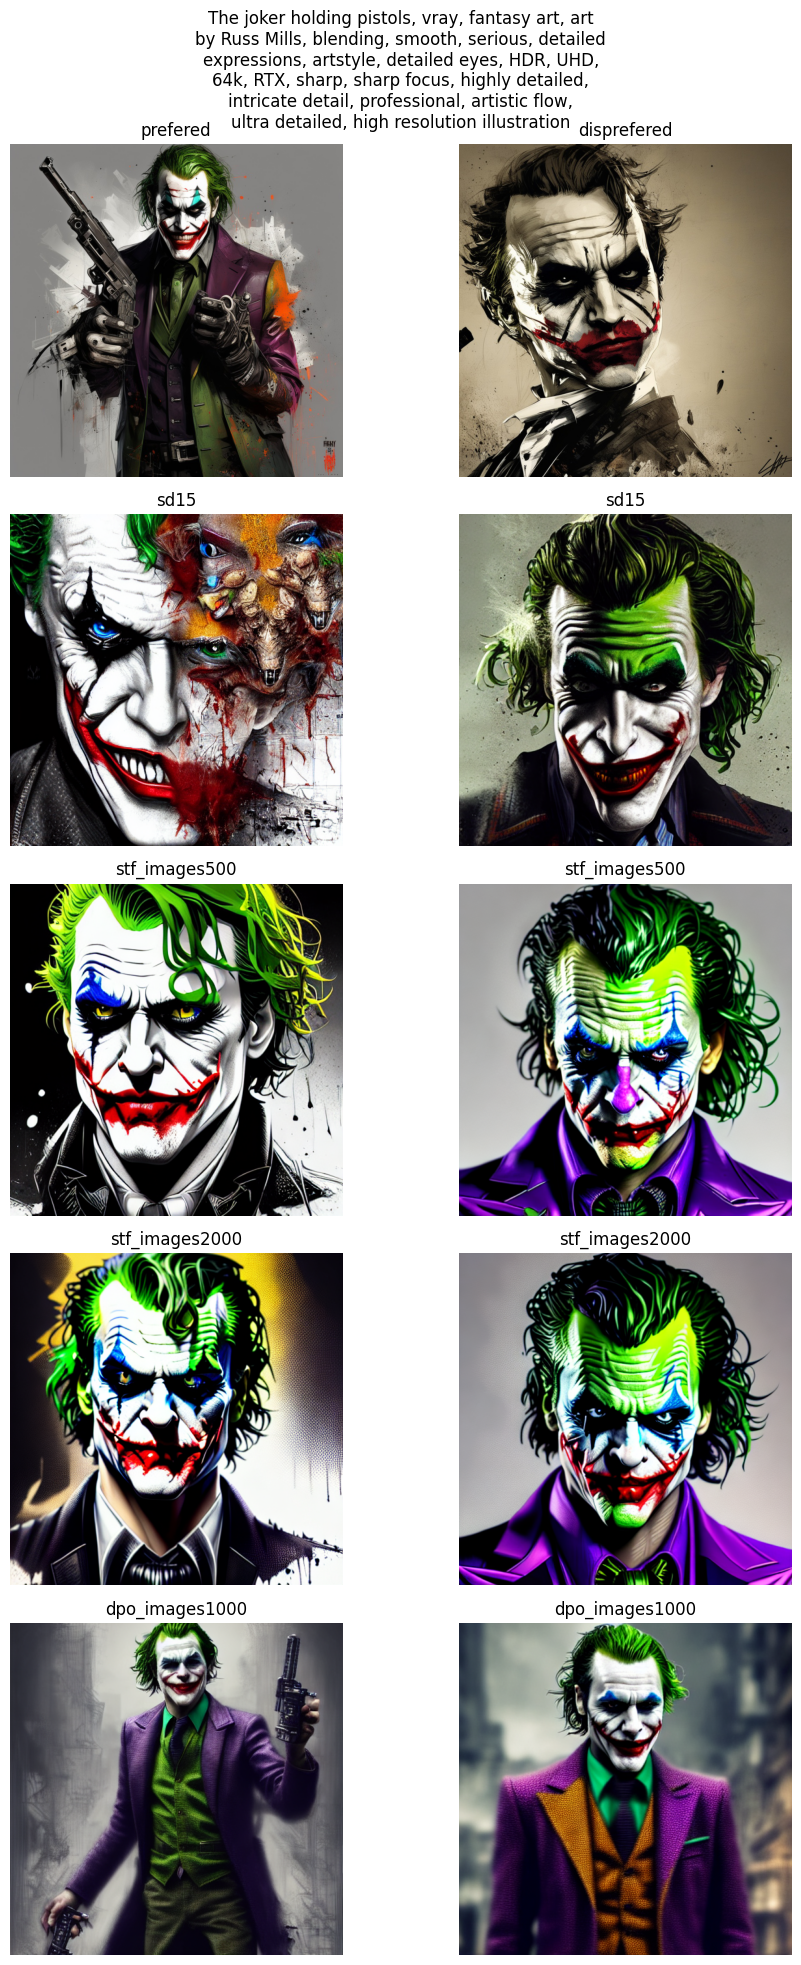

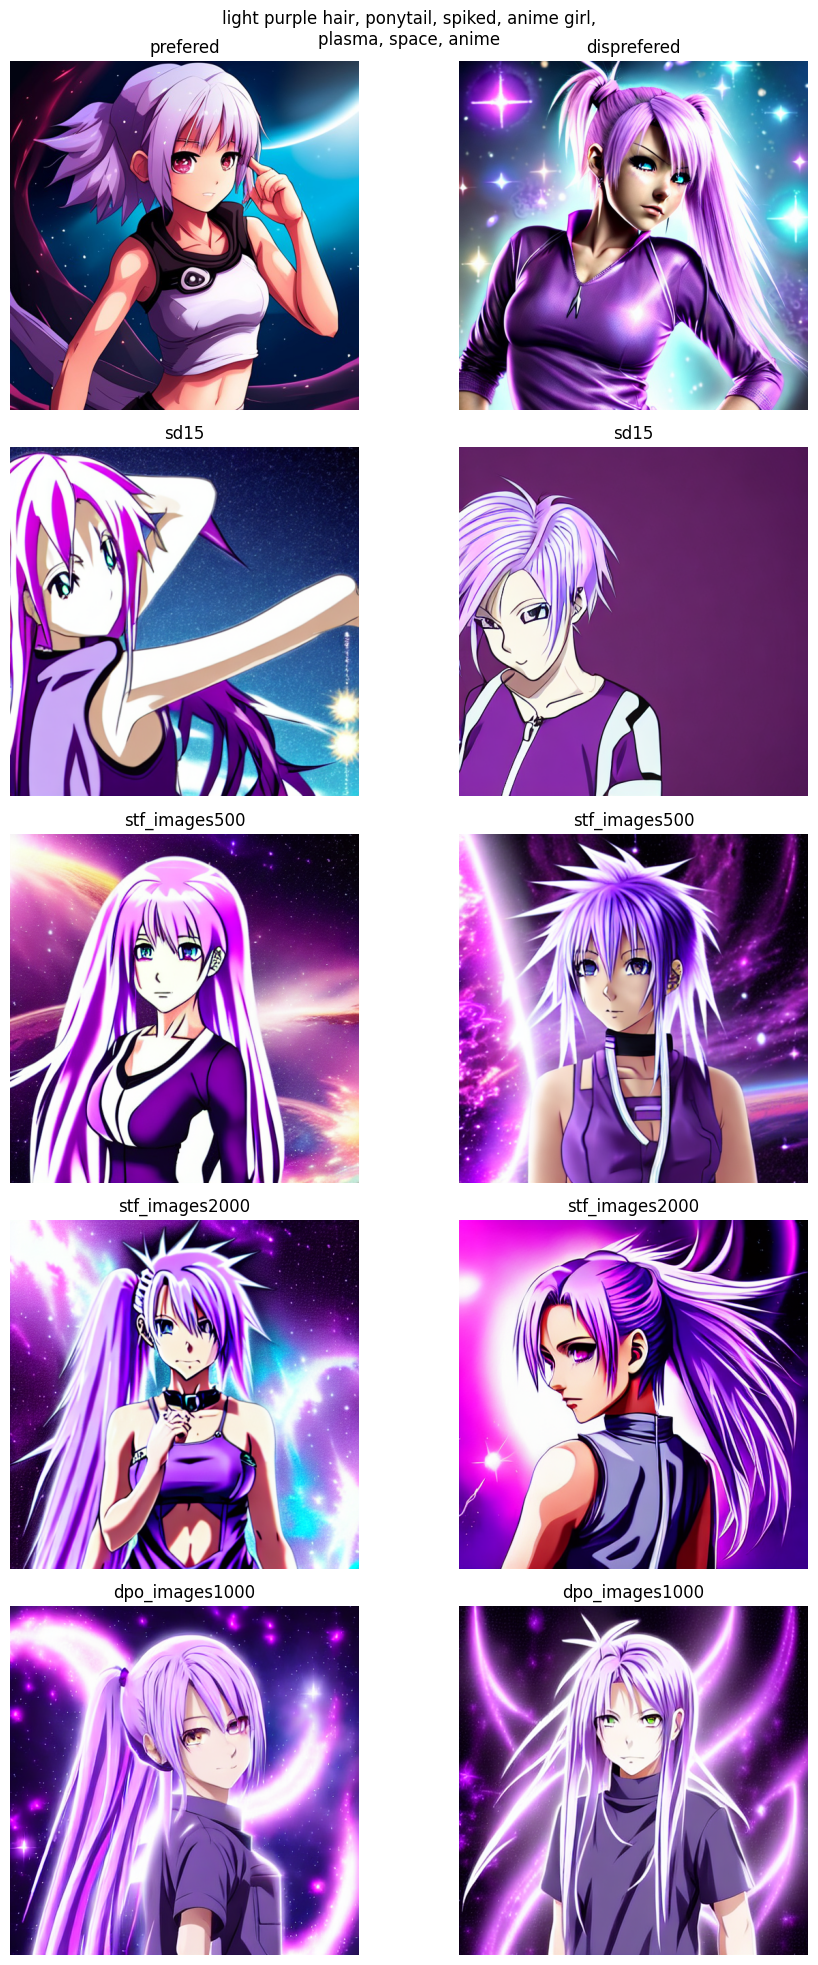

In [35]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import textwrap


for pid, prompt in enumerate(prompts):
    # 创建一个大图
    fig = plt.figure(figsize=(10, 20))
    fig.suptitle( textwrap.fill(prompt, width=50) )
    prompt_n = 0
    ax = fig.add_subplot(len(paths) + 2, 2, 1)
    ax.imshow(raw_images[pid*2+0])
    ax.axis('off')
    ax.set_title("prefered")


    ax = fig.add_subplot(len(paths) + 2, 2, 2)
    ax.imshow(raw_images[pid*2+1])
    ax.axis('off')
    ax.set_title("disprefered")


    ax = fig.add_subplot(len(paths) + 2, 2, 3)
    ax.imshow(baseline_images[pid*2+0])
    ax.axis('off')
    ax.set_title("sd15")


    ax = fig.add_subplot(len(paths) + 2, 2, 4)
    ax.imshow(baseline_images[pid*2+1])
    ax.axis('off')
    ax.set_title("sd15")

    for i in range(len(paths)):
        ax = fig.add_subplot(len(paths) + 2, 2, 2*i+5)
        ax.imshow(path_images[i][0])
        ax.axis('off')
        ax.set_title(paths[i][-30:])

        ax = fig.add_subplot(len(paths) + 2, 2, 2*i+6)
        ax.imshow(path_images[i][1])
        ax.axis('off')
        ax.set_title(paths[i][-30:]


    # 调整子图间距
    plt.tight_layout()
    # 保存图像
    plt.savefig('p{}.png'.format(pid))

    # 显示图像
    plt.show()
